
Ejercicio 1:

Load MNIST train and test sets. Split the original training data into 95% training and 5% validation data.
Implement a convolutional autoencoder (with separate Encoder and Decoder modules). DONE

Train the convolutional autoencoder, with different bottleneck sizes. Plot the train and validation loss curves of all autoencoders in the same figure. TODO

Compute the avg. image reconstruction error (MSE) of the trained models on the MNIST validation and test sets. Show the results in a table, including #params of each model. TODO

Select one of the autoencoders and feed it 5 random MNIST images from the test set. Show them along with their reconstructions. ALMOST DONE

Generate 5 new images by injecting random values as input to the decoder. Show them. GOTTA DO THINGS BEFORE



In [0]:
# Necessary imports, if we don't use them we'll kick them out

import numpy as np
#We'll make it reproducible by using this seed
np.random.seed(1)
import torch
import torch.optim as optim
torch.manual_seed(1)
import torch.nn as nn
import torch.nn.functional as F
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(1)
from torchvision import datasets, transforms
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
# Let's define some hyper-parameters that will be changed
hparams = {
    'batch_size':64,
    'num_epochs':10,
    'val_batch_size':64,
    'test_batch_size':64,
    'hidden_size':128,
    'num_classes':10,
    'num_inputs':784,
    'learning_rate':1e-3,
    'log_interval':100,
    'bottleneck_size':50
}

mnist_trainset = datasets.MNIST('data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ]))
mnist_testset = datasets.MNIST('data', train=False, 
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ]))

length_train = len(mnist_trainset)

#Split the training into validation and training
train_dataset, validation_dataset = torch.utils.data.random_split(mnist_trainset, [int(0.95*length_train), int(0.05*length_train)])


# The argument "drop_last=True" is given in order to ensure that there won't be a last batch that is not full
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=hparams['batch_size'], 
    shuffle=True,drop_last=True) #Probar si peta sin el drop_last pero no es prioritario

val_loader = torch.utils.data.DataLoader(validation_dataset,
                                         batch_size=hparams['val_batch_size'], 
                                         shuffle=True,drop_last=True)

test_loader = torch.utils.data.DataLoader(
    mnist_testset,
    batch_size=hparams['test_batch_size'], 
    shuffle=False,drop_last=True)
print("Thus we have {} full batches of train and {} full batches of validation".format(len(train_loader),len(val_loader)))

Thus we have 890 full batches of train and 46 full batches of validation


Visualization of the data

In [0]:
# Obtain a batch
for i in range(6):
  iterator = iter(train_loader)
  images, labels = iterator.next()
  # We have to transform the image from tensor to numpy
  images = images.numpy()

  # Get first image of the batch
  digit = np.squeeze(images[i])

  fig = plt.figure(figsize = (5,5))
  ax = fig.add_subplot(3,2,i+1)
  ax.imshow(digit, cmap = 'gray')


In [0]:
class Encoder(nn.Module):
   ''' 
   This the encoder part of CAE
   '''

   def __init__(self, bottleneck_size = 30):
     super().__init__()

     self.conv1 = nn.Conv2d(1,16,3,padding=1)
     self.pool  = nn.MaxPool2d(2,2)
     self.conv2 = nn.Conv2d(16,4,3,padding=1)
     self.bottleneck_layer = nn.Linear(4 * 7 * 7, bottleneck_size)
   def forward(self,x):
      ## encode ##
      # add hidden layers with relu activation function
      # and maxpooling after
      x = F.relu(self.conv1(x))
      x = self.pool(x)
      # add second hidden layer
      x = F.relu(self.conv2(x))
      x = self.pool(x)  # compressed representation
      x = x.view(-1, 4 * 7 * 7)
      x = self.bottleneck_layer(x)

      return x

class Decoder(nn.Module):
   ''' 
   This the decoder part of CAE
   '''

   def __init__(self, bottleneck_size=30, bottleneck_layer = None):
     super().__init__()

     ## decoder layers ##
     ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
     self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
     self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)
     self.bottleneck_reconstruct = nn.Linear(bottleneck_size, 4*7*7)

   def forward(self,x):
     ## decode ##
     # add transpose conv layers, with relu activation function
     x = self.bottleneck_reconstruct(x)
     x = x.view(-1, 4, 7, 7)

     x = F.relu(self.t_conv1(x))
     # output layer (with sigmoid for scaling from 0 to 1)
     x = F.sigmoid(self.t_conv2(x))
            
     return x

class CAE(nn.Module):
  '''
  This takes both encoder and decoder into the same network
  '''

  def __init__(self, enc, dec):
    super().__init__()

    self.encoder = enc
    self.decoder = dec

  def forward(self,x):
    #encode
    x = self.encoder(x)
    #Decode
    predicted = self.decoder(x)

    return predicted
      

# Now we have to train the network for a number of epochs
In order to make this in a propper manner we define a train() function

In [0]:
def train(model, num_epochs):
  # Prepare the GPU and the model to start training
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.train()
  model.to(device)
  # First thing is first, specify loss function and optimizer criterion
  # The professor said we should used Mean Square Error
  # From the slides, ADAM was the best optimizer thus:
  costFunc = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr = hparams['learning_rate']) # learning rate chosen at random
  
  for epoch in range(num_epochs):
    # We should track the loss of the model
    closs = 0
    # total = 0
    for batch_idx, (data,_) in enumerate(train_loader):
      # Put data and label into GPU
      data = data.to(device)
      # What does the model say? Pix pix pix pix pix pix pix pix
      prediction = model(data)
      # Compute loss
      loss = costFunc(prediction,data)
      # Save loss to plot it later
      closs += loss.item()*data.size(0) #this data.size(0) is the train_batch_size
      # Careful with the drop_last

      # Name a more iconic trio
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch,closs/len(train_loader)))  
    # Let's check accuracy with our validation set
  #  correctHits = 0

  # for index,(data,_)  in enumerate(val_loader):
  #   data = data.to(device)
  #   prediction = model(data)
  #   _,prediction = torch.max(prediction.data,1) #returns max as well as its index
  #   total += label.size(0)
  #   print('comparison number {} with prediction is {} and validation label is {}'.format(jj,prediction,label))
  #   correctHits += (prediction==label).sum().item()
  # print('Accuracy on epoch ',epoch+1,'= ',str((correctHits/total)*100))


In [0]:
encoder = Encoder(hparams["bottleneck_size"])
decoder = Decoder(hparams["bottleneck_size"])
encoder_decoder = CAE(encoder,decoder)

train(encoder_decoder,30)

In [0]:
# def save_checkpoint(state, filename=PATH + '/checkpoint.pth.tar'):
#     """Save checkpoint if a new best is achieved"""
#     if is_best:
#         print ("=> Saving a new best")
#         torch.save(state, filename)  # save checkpoint

# torch.save()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


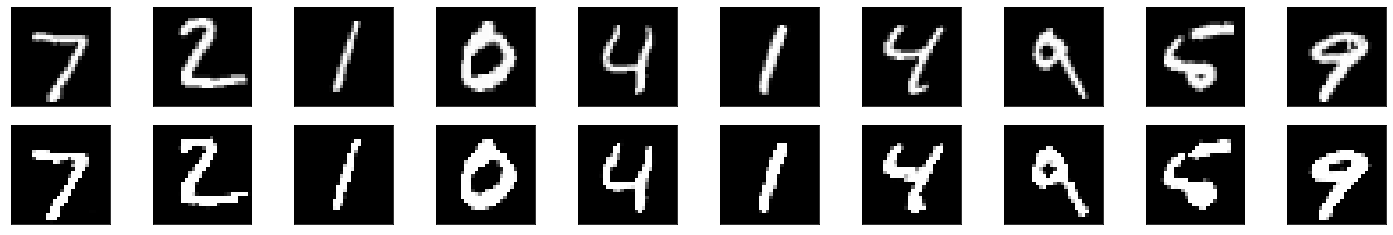

In [0]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, _ = dataiter.next()

encoder_decoder.eval()
encoder_decoder.to("cpu")

# What does the model output?
prediction = encoder_decoder(images)

# prep images for display
images = images.numpy()

# output is resized into a batch of images
#prediction = prediction.view(hparams['test_batch_size'], 1, 28, 28)
# use detach when it's an output that requires_grad and transform to numpy
prediction = prediction.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, prediction], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

I will leave this here as a reference but won't be used in the future as I have already detached the encoder from the decoder.

> Indented block



### Exercice 2

In [0]:
hparams_class = {
    'batch_size':50,
    'num_epochs':30,
    'val_batch_size':50,
    'test_batch_size':50,
    'hidden_size':50,
    'num_classes':10,
    'num_inputs':784,
    'learning_rate':1e-3,
    'log_interval':100,
    'bottleneck_size':50
}

In [0]:
class FeatureClassifier(nn.Module):
  
  def __init__(self, feature_extractor, feature_size, hidden_size, nclasses):
    super().__init__()
    self.feature_extractor = feature_extractor
    
    self.classifier = nn.Sequential(
        torch.nn.Linear(feature_size, hidden_size),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size, hidden_size),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_size, nclasses),
        #torch.nn.Softmax(dim=-1)
    )
    

  def forward(self, x):
    out = self.feature_extractor(x)
    out = self.classifier(out)
    return out


In [0]:
m = FeatureClassifier(Encoder(), 50, 100, 10)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(m)

22860

In [0]:
# From 
def accuracy(output, target):
  """Computes the accuracy for multiple binary predictions"""
  _, index = torch.max(output, dim=1)
  well_predictions = torch.eq(index, target)
  acc = torch.sum(well_predictions, 0)
  
  return acc.float()


In [0]:
def validate(hparams_class, classifier, crit, valid_dataloader, device):
  classifier.eval()

  n = 0
  with torch.no_grad():
    loss = 0
    acc = 0

    for x, label in valid_dataloader:
      x, label = x.to(device), label.to(device)
      
      pred = classifier(x)

      acc += accuracy(pred, label)
      loss += crit(pred, label)
      
      n += label.numel()
  loss = loss / n
  acc = acc / n

  return loss, acc
    

In [0]:
def watch_img(num=2,loader=None ):
  digits = []
  for i in range(num):
    iterator = iter(loader)
    images, _ = iterator.next()

    # Get first image of the batch
    digits.append(images.numpy()[0])

  fig, axes = plt.subplots(nrows=1, ncols=num, sharex=True, sharey=True, figsize=(25,4))

  for images, ax in zip(digits, axes):
      for img in images:
          ax.imshow(np.squeeze(img), cmap='gray')
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)

In [0]:
def train_classifier(hparams_class, classifier, optim, crit, train_dataloader, valid_dataloader, device, name):
  
  classifier.to(device)
  classifier.train()

  N_epoch = hparams_class["num_epochs"]

  metrics =  {"batch_num": [],
              "batch_train_loss": [],
              "epoch_num": [],
              "epoch_val_loss": [],
              "epoch_val_acc": [],
              "epoch_train_loss": [],
              "epoch_train_acc": []
              }


  for n in range(N_epoch):
    for i, (input_batch, target_batch) in enumerate(train_dataloader):
      input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    
      optim.zero_grad()
      prediction = classifier(input_batch)

      loss = crit(prediction, target_batch) / prediction.numel()

      loss.backward()
      optim.step()

      metrics["batch_num"].append(i+1)
      metrics["batch_train_loss"].append(loss.detach().cpu().numpy())

      
    val_loss, val_acc = validate(hparams_class, classifier, crit, valid_dataloader, device)
    
    metrics["epoch_num"].append(n+1)
    metrics["epoch_val_loss"].append(val_loss.detach().cpu().numpy())
    metrics["epoch_val_acc"].append(val_acc.detach().cpu().numpy())
    metrics["epoch_train_loss"].append(np.mean(metrics["batch_train_loss"]))

    print("Epoch {}, Loss: {:.6f}, Acc_val: {:.1f}%,  {}".format(metrics["epoch_num"][n], metrics["epoch_val_loss"][n], metrics["epoch_val_acc"][n]*100, name))
    
    
  metrics = {k: np.array(metrics[k]) for k in metrics.keys()}
  print("-"*55)

  return metrics

Thus we have 2 full batches of train and 60 full batches of validation


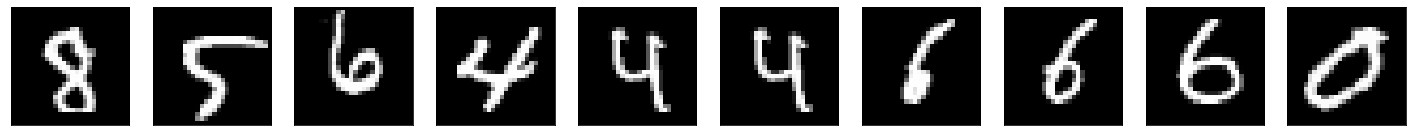

In [0]:



# From scatch
model_scratch = FeatureClassifier(Encoder(hparams_class["bottleneck_size"]), hparams_class["bottleneck_size"], 
                                  hparams_class["hidden_size"], hparams_class["num_classes"])



#Initialize with pretrained ecoder
model_pretrained1 = FeatureClassifier(Encoder(hparams_class["bottleneck_size"]), hparams_class["bottleneck_size"], 
                                      hparams_class["hidden_size"], hparams_class["num_classes"])
model_pretrained1.feature_extractor.load_state_dict(encoder_decoder.encoder.state_dict())

#Initialize with pretrained ecoder
model_pretrained2 = FeatureClassifier(Encoder(hparams_class["bottleneck_size"]), hparams_class["bottleneck_size"], 
                                      hparams_class["hidden_size"], hparams_class["num_classes"])
model_pretrained2.feature_extractor.load_state_dict(encoder_decoder.encoder.state_dict())




small_train_dataset , _ = torch.utils.data.random_split(train_dataset, [100, len(train_dataset) - 100])

small_train_dataloader = torch.utils.data.DataLoader(small_train_dataset, batch_size = hparams_class["batch_size"], shuffle=True)

small_validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size = hparams_class['val_batch_size'], shuffle=True,drop_last=True)




crit = nn.CrossEntropyLoss(reduction="sum")  #nn.BCELoss()


optim1 = optim.Adam(model_scratch.parameters(), lr = hparams['learning_rate']) #From scratch same lr
optim2 = optim.Adam(model_pretrained1.parameters(), lr = hparams['learning_rate']) #From encoder weights same lr
optim3 = optim.Adam([{"params": model_pretrained2.feature_extractor.parameters(), "lr": hparams['learning_rate']/100}, 
                     {"params": model_pretrained2.classifier.parameters(), "lr": hparams['learning_rate']}],)  #From encoder weights diferent lr



watch_img(10, small_train_dataloader)
print("Thus we have {} full batches of train and {} full batches of validation".format(len(small_train_dataloader),len(small_validation_dataloader )))

In [0]:
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu" )
print(device)

model1 = train_classifier(hparams_class, model_scratch, optim1, crit, small_train_dataloader, small_validation_dataloader, device, name="Scratch")
model2 = train_classifier(hparams_class, model_pretrained1, optim2, crit, small_train_dataloader, small_validation_dataloader, device, name="Same lr")
model3 = train_classifier(hparams_class, model_pretrained2, optim3, crit, small_train_dataloader, small_validation_dataloader, device, name="Diff lr")



cuda
Epoch 1, Loss: 2.297370, Acc_val: 18.5%,  Scratch
Epoch 2, Loss: 2.291127, Acc_val: 18.4%,  Scratch
Epoch 3, Loss: 2.285445, Acc_val: 17.4%,  Scratch
Epoch 4, Loss: 2.280436, Acc_val: 13.0%,  Scratch
Epoch 5, Loss: 2.275028, Acc_val: 12.6%,  Scratch
Epoch 6, Loss: 2.272541, Acc_val: 14.2%,  Scratch
Epoch 7, Loss: 2.271049, Acc_val: 18.8%,  Scratch
Epoch 8, Loss: 2.264789, Acc_val: 21.8%,  Scratch
Epoch 9, Loss: 2.252430, Acc_val: 24.4%,  Scratch
Epoch 10, Loss: 2.210282, Acc_val: 26.8%,  Scratch
Epoch 11, Loss: 2.162772, Acc_val: 28.8%,  Scratch
Epoch 12, Loss: 2.109566, Acc_val: 30.8%,  Scratch
Epoch 13, Loss: 2.034227, Acc_val: 34.4%,  Scratch
Epoch 14, Loss: 1.951550, Acc_val: 38.1%,  Scratch
Epoch 15, Loss: 1.851979, Acc_val: 41.3%,  Scratch
Epoch 16, Loss: 1.751010, Acc_val: 43.9%,  Scratch
Epoch 17, Loss: 1.650160, Acc_val: 45.9%,  Scratch
Epoch 18, Loss: 1.543174, Acc_val: 47.7%,  Scratch
Epoch 19, Loss: 1.419317, Acc_val: 51.2%,  Scratch
Epoch 20, Loss: 1.323886, Acc_val: 

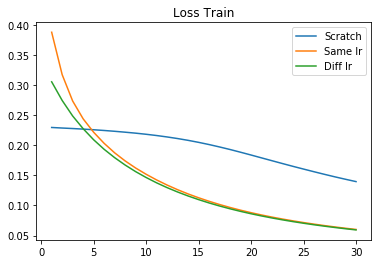

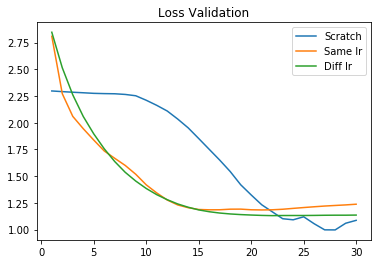

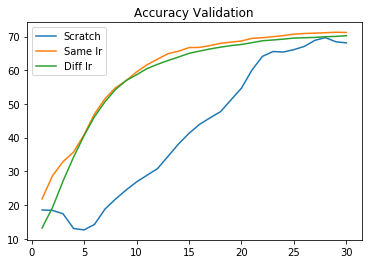

In [0]:

#Loss train Plot
plt.figure()
plt.title("Loss Train")
plt.plot(model1["epoch_num"], model1["epoch_train_loss"], label="Scratch")
plt.plot(model2["epoch_num"], model2["epoch_train_loss"], label="Same lr")
plt.plot(model3["epoch_num"], model3["epoch_train_loss"], label="Diff lr")
plt.legend()

#Loss Validation Plot
plt.figure()
plt.title("Loss Validation")
plt.plot(model1["epoch_num"], model1["epoch_val_loss"], label="Scratch")
plt.plot(model2["epoch_num"], model2["epoch_val_loss"], label="Same lr")
plt.plot(model3["epoch_num"], model3["epoch_val_loss"], label="Diff lr")
plt.legend()

#Accuracy Validation Plot
plt.figure()
plt.title("Accuracy Validation")
plt.plot(model1["epoch_num"], model1["epoch_val_acc"]*100, label="Scratch")
plt.plot(model2["epoch_num"], model2["epoch_val_acc"]*100, label="Same lr")
plt.plot(model3["epoch_num"], model3["epoch_val_acc"]*100, label="Diff lr")
plt.legend()


